# Data split & save

In [1]:
import os
import numpy as np
from pyedflib import highlevel

np.random.seed(0)

In [2]:
def data_1Dto2D(data, Y=9, X=9):
    data_2D = np.zeros([Y, X]) # 나중에 바꾸기
    data_2D[0] = (0,  	   	0, 	        0,          data[0],    data[1],    data[2], 	0,  	    0, 	        0       )
    data_2D[1] = (0,  	   	0,          0,          data[3],    0,          data[4],    0,          0,          0       )
    data_2D[2] = (data[5],  data[6],    data[7],    data[8],    data[9],    data[10],   data[11],   data[12],   data[13])
    data_2D[3] = (data[14], data[15],   data[16],   data[17],   data[18],   data[19],   data[20],   data[21],   data[22])
    data_2D[4] = (data[23], data[24],   data[25],   data[26],   data[27],   data[28],   data[29],   data[30],   data[31])
    data_2D[5] = (data[32], data[33],   data[34],   data[35],   data[36],   data[37],   data[38],   data[39],   data[40])
    data_2D[6] = (data[41], data[42],   data[43],   data[44],   data[45],   data[46],   data[47],   data[48],   data[49])
    data_2D[7] = (0,        data[50],   data[51],   data[52],   data[53],   data[54],   data[55],   data[56],   0       )
    data_2D[8] = (0,        data[57],   0,          data[58],   data[59],   data[60],   0,          data[61],   0       )
    return data_2D

def dataset_1Dto2D(dataset_1D):
    dataset_2D = np.zeros([dataset_1D.shape[0],9,9])
    for i in range(dataset_1D.shape[0]):
        dataset_2D[i] = data_1Dto2D(dataset_1D[i])
    return dataset_2D

def feature_normalize(data):
    mean = data[data.nonzero()].mean()
    sigma = data[data.nonzero()].std()
    data_normalized = data
    data_normalized[data_normalized.nonzero()] = (data_normalized[data_normalized.nonzero()] - mean) / sigma
    return data_normalized

def norm_dataset(dataset_1D, NUM_CHANNEL=64):
    norm_dataset_1D = np.zeros([dataset_1D.shape[0], NUM_CHANNEL])
    for i in range(dataset_1D.shape[0]):
        norm_dataset_1D[i] = feature_normalize(dataset_1D[i])        
    return norm_dataset_1D

def norm_dataset_1Dto2D(dataset_1D):
    norm_dataset_2D = np.zeros([dataset_1D.shape[0],9,9])
    for i in range(dataset_1D.shape[0]):
        norm_dataset_2D[i] = feature_normalize(data_1Dto2D(dataset_1D[i]))
    return norm_dataset_2D

def windows(data, size):
    start = 0
    while ((start+size) < data.shape[0]):
        yield int(start), int(start + size)
        start += size

def segment_signal_without_transition(data, window_size=160):
    for (start, end) in windows(data, window_size):
        if((len(data[start:end]) == window_size)):
            if start == 0:
                segments = np.array(data[start:end])
            else:
                segments = np.vstack([segments, data[start:end]])
    return segments

def delete_base_mean(signal, sampling_rate=160, yes_or_not='yes'):
    total_len = int(len(signal)/sampling_rate)
    base_signal = (signal[0:1*sampling_rate,:] + signal[1*sampling_rate:2*sampling_rate,:] + signal[2*sampling_rate:3*sampling_rate,:]) / 3 if yes_or_not == 'yes' else 0
    for i in range(total_len):# delete base mean
        signal[i*sampling_rate:(i+1)*sampling_rate, :] = signal[i*sampling_rate:(i+1)*sampling_rate, :] - base_signal
    signal = norm_dataset(signal) # normalize data
    return signal

In [36]:
MMI_SUBJECT = 109
MMI_TRIAL = 14
MMI_CHANNEL = 64
DUR = 4
SAMPLING_RATE = 160
yes_or_not = 'yes'

file_path = './eegmmidb_edf/S'
save_path = './eegmmidb_emoticon_feature/S'

left_right_chapter = [3, 4, 7, 8, 11, 12]
feet_hand_chapter = [5, 6, 9, 10, 13, 14]
problem_files = [87, 91, 99]

for i in range(103, MMI_SUBJECT):
    if i in problem_files: continue
    MMI_right_hand = np.empty((0, 64))
    MMI_left_hand = np.empty((0, 64))
    MMI_both_hand = np.empty((0, 64))
    MMI_both_feet = np.empty((0, 64))
    
    for j in range(1, MMI_TRIAL+1):
        path = file_path + str(i+1).zfill(3) + '/s' +str(i+1).zfill(3) + 'R' + str(j).zfill(2) + '.edf'
        if j in left_right_chapter:
            # read edf files
            signals, signal_header, header = highlevel.read_edf(path)
            signals = signals.transpose(1, 0)
            labels = header['annotations']
            
            # base mean 제거
            delete_base_mean(signals)
            # label에 따라 분류
            for label in labels:
                start_point = int(label[0]*SAMPLING_RATE)
                DUR = int(label[1])
                if label[2] == 'T1': #left fist
                    MMI_left_hand = np.append(MMI_left_hand, signals[start_point:start_point + DUR*SAMPLING_RATE, :], axis=0)
                elif label[2] == 'T2': #right fist
                    MMI_right_hand = np.append(MMI_right_hand, signals[start_point:start_point + DUR*SAMPLING_RATE, :], axis=0)
        elif j in feet_hand_chapter:
            # read edf files
            signals, signal_header, header = highlevel.read_edf(path)
            signals = signals.transpose(1, 0)
            labels = header['annotations']
            # base mean 제거
            delete_base_mean(signals)
            # label에 따라 분류
            for label in labels:
                start_point = int(label[0]*SAMPLING_RATE)
                DUR = int(label[1])
                if label[2] == 'T1': # both hand
                    MMI_both_hand = np.append(MMI_both_hand, signals[start_point:start_point + DUR*SAMPLING_RATE, :], axis=0)
                elif label[2] == 'T2': # both feet
                    MMI_both_feet = np.append(MMI_both_feet, signals[start_point:start_point + DUR*SAMPLING_RATE, :], axis=0)
    
    
    left_hand_E = dataset_1Dto2D(MMI_left_hand)
    right_hand_E = dataset_1Dto2D(MMI_right_hand)
    both_hand_E = dataset_1Dto2D(MMI_both_hand)
    both_feet_E = dataset_1Dto2D(MMI_both_feet)
    
    left_hand_E = np.reshape(left_hand_E, (-1, SAMPLING_RATE, 9, 9))
    right_hand_E = np.reshape(right_hand_E, (-1, SAMPLING_RATE, 9, 9))
    both_hand_E = np.reshape(both_hand_E, (-1, SAMPLING_RATE, 9, 9))
    both_feet_E = np.reshape(both_feet_E, (-1, SAMPLING_RATE, 9, 9))
    
    MMI_left_hand = np.reshape(MMI_left_hand, (-1, SAMPLING_RATE, MMI_CHANNEL))
    MMI_right_hand = np.reshape(MMI_right_hand, (-1, SAMPLING_RATE, MMI_CHANNEL))
    MMI_both_hand = np.reshape(MMI_both_hand, (-1, SAMPLING_RATE, MMI_CHANNEL))
    MMI_both_feet = np.reshape(MMI_both_feet, (-1, SAMPLING_RATE, MMI_CHANNEL))
    
    path = save_path + str(i+1).zfill(3)
    if not os.path.exists(path): os.makedirs(path)
    np.save(path+'/left_hand_E', left_hand_E)
    np.save(path+'/right_hand_E', right_hand_E)
    np.save(path+'/both_hand_E', both_hand_E)
    np.save(path+'/both_feet_E', both_feet_E)
    np.save(path+'/left_hand_C', MMI_left_hand)
    np.save(path+'/right_hand_C', MMI_right_hand)
    np.save(path+'/both_hand_C', MMI_both_hand)
    np.save(path+'/both_feet_C', MMI_both_feet)

# Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

torch.cuda.manual_seed_all(1234)
np.random.seed(1234)

MMI_SUBJECT = 109
MMI_TRIAL = 14
MMI_CHANNEL = 64
SAMPLING_RATE = 160
BATCH_SIZE = 240
N_EPOCH = 50

In [2]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel=(5,5), stride=1, padding=1):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel, stride=stride, padding=padding, groups=nin)
        nn.init.kaiming_normal_(self.depthwise.weight)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)
        nn.init.kaiming_normal_(self.pointwise.weight)
        
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
    
class EmotionNet(nn.Module):
    def __init__(self, input_image=torch.zeros(1, 40, 1, 9, 9), kernel=(5,5), 
                 stride=1, padding=1, n_classes=4, n_units=128):
        super(EmotionNet, self).__init__()
        
        n_window = input_image.shape[1]
        n_channel = input_image.shape[2]
        
        # EEG-EmotionNet 2D ConvNet
        self.conv1 = depthwise_separable_conv(n_channel, 32, kernel, stride=stride, padding=padding)
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = depthwise_separable_conv(32, 64, kernel, stride=stride, padding=padding)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = depthwise_separable_conv(64, 128, kernel, stride=stride, padding=padding)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        
        # EEG-EmotionNet Temporal 1D CNN
        self.conv4 = nn.Conv2d(3 * 3 * 128, 128, (40, 1), stride=stride, padding=0)
        nn.init.kaiming_normal_(self.conv4.weight)
        
        self.fc = nn.Linear(128, 128)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.max = nn.LogSoftmax()
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 3, 3).cuda()
        else:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 3, 3).cpu()
        for i in range(x.shape[1]):
            img = x[:, i]
            img = self.conv1(img) # 9x9 -> 7x7
            img = F.elu(self.BatchNorm1(img))
            img = self.conv2(img) # 7x7 -> 5x5
            img = F.elu(self.BatchNorm2(img))
            img = self.conv3(img) # 5x5 -> 3x3
            img = F.elu(self.BatchNorm3(img))
            tmp[:, i] = img
            del img
        
        temp_conv = F.elu(self.conv4(tmp.reshape(x.shape[0], 3*128*3, x.shape[1], 1)))
        temp_conv = temp_conv.reshape(temp_conv.shape[0], -1)
        del tmp
        x = temp_conv
        x = F.elu(self.fc(x))
        embedding = F.elu(self.fc1(x))
        x = self.fc2(embedding)
        return x, embedding

# DataLoader

In [3]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import StepLR

In [6]:
def kfold(length, n_fold):
    total_id = np.arange(length)
    np.random.shuffle(total_id)
    len_fold = int(length/n_fold)
    train_id = []
    test_id = []
    for i in range(n_fold):
        test_id.append(total_id[i*len_fold:(i+1)*len_fold])
        train_id.append(np.hstack([total_id[0:i*len_fold], total_id[(i+1)*len_fold:-1]]))
    return train_id, test_id

class EEGImagesDataset(Dataset):
    def __init__(self, label, image):
        self.label = label
        self.images = image
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.images[idx]
        label = self.label[idx]
        sample = (image, label)
        
        return sample

def test_model(Model, testloader, criterion, is_cuda=True):
    running_loss = 0.0
    evaluation = []
    
    for i, data in enumerate(testloader, 0):
        input_img, labels = data
        labels = labels.long()
        input_img = input_img.to(torch.float32)
        if is_cuda:
            input_img = input_img.cuda()
        outputs, _ = Model(input_img)
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted==labels).tolist())
        
        loss = criterion(outputs, labels.cuda())
        running_loss += loss.item()
    
    running_loss = running_loss / (i + 1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    return running_loss, running_acc

def traintest_model(Model, trainloader, testloader, n_epoch=50, opti='SGD', learning_rate=0.0001,
                    is_cuda=True, verbose=False):
    if is_cuda:
        model = Model().cuda()
    else:
        model = Model()
    
    criterion = nn.CrossEntropyLoss()
    
    if opti == 'SGD': optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif opti == 'Adam': optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else: print('Optimizer not implemented')
    
    val_best = 0
    exp_lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    
    for epoch in range(n_epoch):
        running_loss = 0.0
        evaluation = []
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.long()
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs, embedding = model(inputs.to(torch.float32).cuda())
            _, predicted = torch.max(outputs.cpu().data, 1)
            evaluation.append((predicted==labels).tolist())
            
            #backward
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            
            #optimize
            optimizer.step()
            
            running_loss += loss.item()
        exp_lr_scheduler.step()
        
        running_loss = running_loss/(i+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        running_acc = sum(evaluation) / len(evaluation)
        validation_loss, validation_acc = test_model(model, testloader, criterion, True)
        
        if validation_acc > val_best:
            val_best = validation_acc
            res = [running_loss, running_acc, validation_loss, validation_acc]
        print('Intention\t [%d, %4d]\tloss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
              (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    if verbose:
        print('Finished Training Emotion \n loss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
                 (running_loss, running_acc, validation_loss,validation_acc))
    return res

In [5]:
data_path = './eegmmidb_emoticon_feature/S'

problem_files = [87, 91, 99]

feature_len = [0]
train_data = np.empty([0, 40, 9, 9])
label = []

def get_input_feature(train_data, feature_len, file='/left_hand_E.npy'):
    for i in range(MMI_SUBJECT):
        if i in problem_files: continue
        left_hand_E = np.load(data_path + str(i+1).zfill(3) + file)
        for i in range(40):
            temp = np.empty((left_hand_E.shape[0], 40, 9, 9))
            temp[:, i, :, :] = np.mean(left_hand_E[:,i*4:(i+1)*4,:,:], axis=1)
        train_data = np.vstack([train_data, temp])
        feature_len.append(len(train_data))
    return train_data, feature_len

def get_label(label_arr, a, b, label):
    for i in range(a-b): label_arr.append(label)
    return label_arr

length = 0
train_data, feature_len = get_input_feature(train_data, feature_len, file='/left_hand_E.npy')
label = get_label(label, len(train_data), length, 0)
length = len(train_data)

train_data, feature_len = get_input_feature(train_data, feature_len, file='/right_hand_E.npy')
label = get_label(label, len(train_data), length, 1)
length = len(train_data)

train_data, feature_len = get_input_feature(train_data, feature_len, file='/both_hand_E.npy')
label = get_label(label, len(train_data), length, 2)
length = len(train_data)

train_data, feature_len = get_input_feature(train_data, feature_len, file='/both_feet_E.npy')
label = get_label(label, len(train_data), length, 3)
train_data = np.expand_dims(train_data, axis=2)

In [6]:
import time
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader

EEG_train = EEGImagesDataset(label=label, image=train_data)
n_fold = 10
train_id, test_id = kfold(len(EEG_train), n_fold)

Result = []
for r in range(n_fold):
    print("time begin:", time.localtime())
    Train = Subset(EEG_train, train_id[r])
    Test = Subset(EEG_train, test_id[r])
    Trainloader = DataLoader(Train, batch_size=BATCH_SIZE)
    Testloader = DataLoader(Test, batch_size=BATCH_SIZE)
    res = traintest_model(EmotionNet, Trainloader, Testloader, n_epoch=N_EPOCH, 
                          learning_rate=0.001, opti='Adam')
    print('\n Training for {} fold'.format(r+1))
    print('Intention End Training with \t loss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
        (res[0], res[1], res[2], res[3]))
    Result.append(res)

Result = np.mean(Result, axis=0)
print('-'*20)
print('Intention End Training with \t loss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
    (Result[0], Result[1], Result[2], Result[3]))

time begin: time.struct_time(tm_year=2022, tm_mon=11, tm_mday=18, tm_hour=0, tm_min=10, tm_sec=15, tm_wday=4, tm_yday=322, tm_isdst=0)
Intention	 [1,   50]	loss: 0.8370	Accuracy : 0.9834		val-loss: 165.2443	val-Accuracy : 0.0000
Intention	 [2,   50]	loss: 3.0310	Accuracy : 0.9755		val-loss: 533.5561	val-Accuracy : 0.0000
Intention	 [3,   50]	loss: 6.4566	Accuracy : 0.9650		val-loss: 255.9822	val-Accuracy : 0.0000
Intention	 [4,   50]	loss: 11.9758	Accuracy : 0.9405		val-loss: 116.9909	val-Accuracy : 0.0000
Intention	 [5,   50]	loss: 2.2780	Accuracy : 0.9300		val-loss: 27.5229	val-Accuracy : 0.0000
Intention	 [6,   50]	loss: 0.7526	Accuracy : 0.8636		val-loss: 8.5769	val-Accuracy : 0.0000
Intention	 [7,   50]	loss: 0.7799	Accuracy : 0.8077		val-loss: 6.9650	val-Accuracy : 0.0000
Intention	 [8,   50]	loss: 0.7115	Accuracy : 0.7867		val-loss: 7.5180	val-Accuracy : 0.0000
Intention	 [9,   50]	loss: 0.8048	Accuracy : 0.7832		val-loss: 5.7562	val-Accuracy : 0.0000
Intention	 [10,   50]	loss:

KeyboardInterrupt: 

# Meta EEG Training

In [11]:
import time
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader

learning_rate = 0.0001
n_epoch = 50
n_fold = 10
Result = []

QUERY_STEP = 10
EEG_train = EEGImagesDataset(label=label, image=train_data)
n_fold = 10
train_id, test_id = kfold(len(EEG_train), n_fold)

# define meta-loss
def meta_loss(output_embeddings, labels, avg_embeddings):
    distances = 0
    for idx in range(len(output_embeddings)):
        temp = 0
        for k in range(len(avg_embeddings)):
            if labels[idx] == k:
                distances += torch.sum(torch.abs(output_embeddings[idx] - avg_embeddings[k]))
            else:
                temp += torch.exp(torch.sum(-torch.abs(output_embeddings[idx] - avg_embeddings[k])))
        distances += torch.log(temp)
    distances /= len(output_embeddings)
    return distances

print("time begin:", time.localtime())
for r in range(n_fold):
    print('\n Training for {} fold'.format(r+1))
    
    Train = Subset(EEG_train, train_id[r])
    Test = Subset(EEG_train, test_id[r])
    Trainloader = DataLoader(Train, batch_size=BATCH_SIZE)
    Testloader = DataLoader(Test, batch_size=BATCH_SIZE)
    
    # spilt query sample and support sample
    # random sampling only
    # query set is implemented every 10 steps 
    
    # load model & set criterion, optimizer
    model = EmotionNet().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    val_best = 0
    exp_lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    
    for epoch in range(n_epoch):
        embeddings = np.zeros((4, 128)) # save each classes' embeddings
        labels_count = np.zeros(4) # get labels count
        num_of_step = 1
        running_loss = 0.0
        evaluation = []
        
        for i, data in enumerate(Trainloader):
            if num_of_step % QUERY_STEP == 0: # query set training (every 10 stepts)
                # get average embeddings
                for i in range(len(embeddings)):
                    embeddings[i] /= labels_count[i]
                embeddings = torch.Tensor(embeddings).cuda() # for loss calculation
                
                # get the inputs
                inputs, labesl = data
                labels = labels.long()
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs, embedding = model(inputs.to(torch.float32).cuda())
                
                # backward
                loss = meta_loss(embedding, labels, embeddings) # get meta loss
                loss.backward()
                
                # optimize
                optimizer.step()
                
                embeddings = np.zeros((4, 128)) # initialize embedding averagess
                labels_count = np.zeros(4) # initialize label count
            
            else: # support set training
                # get the inputs
                inputs, labels = data
                labels = labels.long()
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs, embedding = model(inputs.to(torch.float32).cuda())
                _, predicted = torch.max(outputs.cpu().data, 1)
                evaluation.append((predicted==labels).tolist())
                
                # backward
                loss = criterion(outputs, labels.cuda())
                loss.backward()
                
                # optimize
                optimizer.step()
                
                # get sum of embeddings
                for idx, i in enumerate(labels):
                    embeddings[i] += embedding[idx].cpu().detach().data.numpy()
                    labels_count[i] += 1
                
                running_loss += loss.item()
        exp_lr_scheduler.step()
        
        running_loss = running_loss/(i+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        running_acc = sum(evaluation) / len(evaluation)
        validation_loss, validation_acc = test_model(model, Testloader, criterion, True)
        
        if validation_acc > val_best:
            val_best = validation_acc
            res = [running_loss, running_acc, validation_loss, validation_acc]
        print('Intention\t [%d, %4d]\tloss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
              (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    
    print('Finished Training Intention \n loss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
            (running_loss, running_acc, validation_loss,validation_acc))
    
    Result.append(res)

Result = np.mean(Result, axis=0)
print('-'*20)
print('Intention End Training with \t loss: %.4f\tAccuracy : %.4f\t\tval-loss: %.4f\tval-Accuracy : %.4f' %
    (Result[0], Result[1], Result[2], Result[3]))

time begin: time.struct_time(tm_year=2022, tm_mon=11, tm_mday=18, tm_hour=0, tm_min=30, tm_sec=20, tm_wday=4, tm_yday=322, tm_isdst=0)

 Training for 1 fold
Intention	 [1,   50]	loss: 99.7606	Accuracy : 0.2567		val-loss: 1.3867	val-Accuracy : 0.2589
Intention	 [2,   50]	loss: 99.4098	Accuracy : 0.2687		val-loss: 1.3838	val-Accuracy : 0.2694


KeyboardInterrupt: 

# Meta Learning results

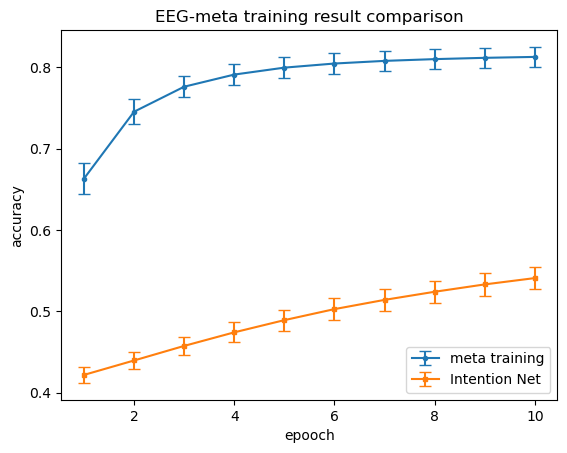

In [92]:
import numpy as np
import matplotlib.pyplot as plt

result_file = 'D:/data set/EEG emotion/EEGMMIDB/result/EEG-intention_meta_result.txt'
f = open(result_file, 'r')

results = []
while True:
    line = f.readline()
    if not line:break
    if (len(line) < 8) and (line != '\n'):
        results.append(float(line[:-1]))

normal_results = np.array(results[500:]).reshape((-1,10))
meta_results = np.array(results[:500]).reshape((-1,10))

normal_avg = np.mean(normal_results, axis=0)
meta_avg = np.mean(meta_results, axis=0)
normal_std = np.std(normal_results, axis=0)
meta_std = np.std(meta_results, axis=0)

plt.figure()
plt.errorbar(epoch, normal_avg, yerr=normal_std, capsize=4, marker='o', markersize=3, label='meta training')
plt.errorbar(epoch, meta_avg, yerr=meta_std, capsize=4, marker='s', markersize=3, label='Intention Net')
plt.title('EEG-meta training result comparison')
plt.xlabel('epooch')
plt.ylabel('accuracy')
plt.legend()
plt.show()